# Download
First we need to download all files from the server and combine them into a single dataframe

In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev, median


files = os.listdir('data')
print(files)
df = pd.concat([pd.read_csv('data/' + file) for file in files], ignore_index=True)

['part3.csv', 'part4.csv', 'part5.csv', 'part6.csv', 'part7.csv', 'part8.csv', 'part9.csv']


# Mean times for each setting

In [37]:
mean_time_to_finish_dark_mode = df[df["ui_mode"] == "dark_mode"]["time_to_finish"].mean()
mean_time_to_finish_light_mode = df[df['ui_mode'] == 'light_mode']['time_to_finish'].mean()
mean_time_to_finish_combined = df['time_to_finish'].mean()

median_time_to_finish_dark_mode = df[df["ui_mode"] == "dark_mode"]["time_to_finish"].median()
median_time_to_finish_light_mode = df[df['ui_mode'] == 'light_mode']['time_to_finish'].median()
median_time_to_finish_combined = df['time_to_finish'].median()

print(mean_time_to_finish_dark_mode)
print(mean_time_to_finish_light_mode)
print(mean_time_to_finish_combined)

print(median_time_to_finish_dark_mode)
print(median_time_to_finish_light_mode)
print(median_time_to_finish_combined)

10721.15205724508
7073.560714285714
8895.72654155496
5457.0
3644.5
4376.0


Text(0, 0.5, 'Times')

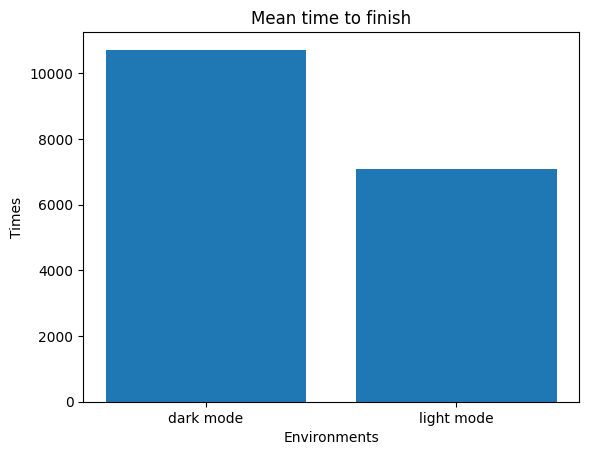

In [38]:
visualization = plt.bar(['dark mode', 'light mode'],[mean_time_to_finish_dark_mode, mean_time_to_finish_light_mode])
plt.title('Mean time to finish')
plt.xlabel('Environments')
plt.ylabel('Times')

In [39]:
mean_time_to_finish_dark_mode_dark_env = df[(df["ui_mode"] == "dark_mode") & (df['environment'] == 'dark_env')]["time_to_finish"].mean()
mean_time_to_finish_light_mode_light_env = df[(df['ui_mode'] == 'light_mode') & (df['environment'] == 'light_env')]['time_to_finish'].mean()
mean_time_to_finish_dark_mode_light_env = df[(df["ui_mode"] == "dark_mode") & (df['environment'] == 'light_env')]["time_to_finish"].mean()
mean_time_to_finish_light_mode_dark_env = df[(df['ui_mode'] == 'light_mode') & (df['environment'] == 'dark_env')]['time_to_finish'].mean()

modes_with_environments = [mean_time_to_finish_dark_mode_dark_env, mean_time_to_finish_dark_mode_light_env, mean_time_to_finish_light_mode_light_env, mean_time_to_finish_light_mode_dark_env]

print(modes_with_environments)

[np.float64(11210.885714285714), np.float64(10229.663082437275), np.float64(7465.282142857143), np.float64(6681.839285714285)]


Text(0, 0.5, 'Times')

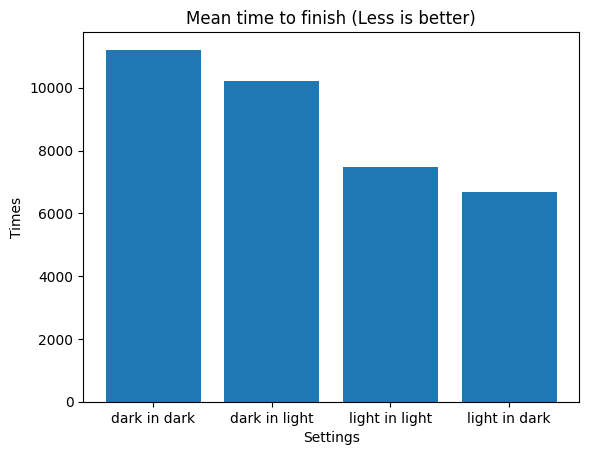

In [41]:
visualization = plt.bar(['dark in dark', 'dark in light', 'light in light', 'light in dark'], modes_with_environments)
plt.title('Mean time to finish (Less is better)')
plt.xlabel('Settings')
plt.ylabel('Times')

In [ ]:
ttf_o_e = df[(df["fill_character"] == "o") | (df['outlier_character'] == 'o')]["time_to_finish"].mean()
ttf_0_8 = df[(df["fill_character"] == "0") | (df['outlier_character'] == '0')]["time_to_finish"].mean()
ttf_v_u = df[(df["fill_character"] == "v") | (df['outlier_character'] == 'v')]["time_to_finish"].mean()
ttf_7_T = df[(df["fill_character"] == "7") | (df['outlier_character'] == '7')]["time_to_finish"].mean()

filler_outlier_means = [ttf_o_e, ttf_0_8, ttf_v_u, ttf_7_T]
print(filler_outlier_means)

[np.float64(4757.0), np.float64(9295.5), np.float64(3352.0), np.float64(2904.0)]


Text(0, 0.5, 'Times')

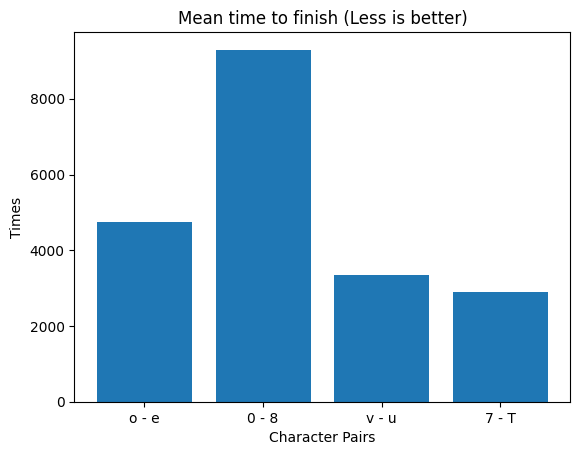

In [46]:
visualization = plt.bar(['o - e', '0 - 8', 'v - u', '7 - T'], filler_outlier_means)
plt.title('Mean time to finish (Less is better)')
plt.xlabel('Character Pairs')
plt.ylabel('Times')